#                                                 Overview
This dataset contains every wholesale purchase of liquor in the State of Iowa by retailers for sale to individuals since January 1, 2012. The State of Iowa controls the wholesale distribution of liquor intended for retail sale, which means this dataset offers a complete view of retail liquor sales in the entire state. The dataset contains every wholesale order of liquor by all grocery stores, liquor stores, convenience stores, etc., with details about the store and location, the exact liquor brand and size, and the number of bottles ordered.

In addition to being an excellent dataset for analyzing liquor sales, this is a large and clean public dataset of retail sales data. It can be used to explore problems like stockout prediction, retail demand forecasting, and other retail supply chain problems.

In [182]:
# First, import the relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from functools import reduce
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # What does this do? Find out and type here.
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from sklearn.metrics import mean_squared_error, r2_score # What does this do? Find out and type here.
from sklearn.model_selection import train_test_split # For splitting the data.
from sklearn import linear_model, preprocessing # What does this do? Find out and type here.
import json
import requests
from collections import defaultdict
import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# 1a. Source and load the data
Here I will load iowa_liquor_sales dataset from the IOWA government site using their API.

In [183]:
url = 'https://data.iowa.gov/resource/m3tr-qhgy.json'
r = requests.get(url)
json_data = r.json()

In [184]:
Iowa_Liquor_Sales_API = 'https://data.iowa.gov/resource/m3tr-qhgy.csv'
iowa_liquor_sales = pd.read_csv(Iowa_Liquor_Sales_API, index_col=0)


# Exploring the data

In [185]:
iowa_liquor_sales.describe()

,store,zipcode,county_number,category,vendor_no,itemno,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_liters,sale_gallons
count,1000.00000,762.000000,752.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3847.83500,51203.181102,59.389628,1.036496e+06,264.735000,39493.930000,12.29900,897.900000,10.033650,15.052400,9.907000,131.136120,8.683710,2.289170
std,1116.42909,1008.063791,25.706601,5.867247e+04,138.038891,59363.226262,7.65233,510.053423,7.749894,11.624899,17.295592,470.516239,21.153072,5.588366
min,2190.00000,50009.000000,2.000000,1.011100e+06,35.000000,258.000000,1.00000,50.000000,0.900000,1.350000,1.000000,2.700000,0.050000,0.010000
25%,2625.00000,50311.000000,47.000000,1.012100e+06,115.000000,23826.000000,6.00000,600.000000,5.400000,8.100000,3.000000,36.000000,1.750000,0.460000
50%,3848.50000,51040.000000,70.000000,1.031100e+06,260.000000,35318.000000,12.00000,750.000000,7.895000,11.845000,6.000000,66.960000,6.000000,1.580000
75%,4947.00000,52244.750000,78.000000,1.041100e+06,380.000000,40595.250000,12.00000,1000.000000,13.000000,19.500000,12.000000,135.000000,10.500000,2.770000
max,6062.00000,52807.000000,97.000000,1.901200e+06,626.000000,927618.000000,48.00000,1850.000000,99.990000,149.990000,300.000000,13806.000000,525.000000,138.690000


In [186]:
iowa_liquor_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, S31296100034 to INV-20339300007
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1000 non-null   object 
 1   store                1000 non-null   int64  
 2   name                 1000 non-null   object 
 3   address              762 non-null    object 
 4   city                 762 non-null    object 
 5   zipcode              762 non-null    float64
 6   store_location       227 non-null    object 
 7   county_number        752 non-null    float64
 8   county               752 non-null    object 
 9   category             1000 non-null   int64  
 10  category_name        997 non-null    object 
 11  vendor_no            1000 non-null   int64  
 12  vendor_name          1000 non-null   object 
 13  itemno               1000 non-null   int64  
 14  im_desc              1000 non-null   object 
 15  pack                 

In [187]:
iowa_liquor_sales.shape

(1000, 23)

# 1b. Picking the right the columns
From the documentation of this dataset, I can see that some appropriate columns to look at to answer the brief are:

date
name
category
category_name
vendor_name
bottle_volume_ml
state_bottle_cost
state_bottle_retail 
sale_bottles        
sale_dollars                 
sale_gallons 

# 1c. Subsetting accordingly
Here I will select only those columns that I want to work with from this dataset. I'll overwrite the subsets in the original variables.

In [188]:
# Subset the DataFrame object iowa_liquor_sales by selecting just the variables
iowa_liquor_sales = iowa_liquor_sales[['date','name','category','category_name',
                                       'vendor_name','bottle_volume_ml',
                                       'state_bottle_cost','state_bottle_retail','sale_bottles',
                                       'sale_dollars','sale_gallons']]
# Exploring the data
# Check the first three entries
iowa_liquor_sales.head()

,date,name,category,category_name,vendor_name,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_gallons
invoice_line_no,,,,,,,,,,,
S31296100034,2016-03-16T00:00:00.000,Wine and Spirits Gallery,1081200,CREAM LIQUEURS,Gemini Spirits,1000,7.23,10.85,1,10.85,0.26
INV-20599500022,2019-07-15T00:00:00.000,Fareway Stores #470 / Perry,1012200,Scotch Whiskies,SAZERAC COMPANY INC,1750,10.50,15.75,6,94.50,2.77
INV-28403900139,2020-07-01T00:00:00.000,Hy-Vee Wine and Spirits / Waterloo,1012400,Irish Whiskies,PERNOD RICARD USA,1750,32.48,48.72,2,97.44,0.92
INV-20560900100,2019-07-11T00:00:00.000,Quick Shop / Clear Lake,1012200,Scotch Whiskies,SAZERAC COMPANY INC,1000,6.74,10.11,2,20.22,0.52
INV-20784900043,2019-07-23T00:00:00.000,IDA Liquor,1701100,Temporary & Specialty Packages,DIAGEO AMERICAS,1850,18.00,27.00,6,162.00,2.93


# 1d. Choosing a dependent variable
I need to pick a dependent variable for my regression analysis: a variable whose values I will predict.

'sale_bottles' seems to be as good a candidate. One of the quickest and most informative ways to understand a variable is to make a histogram of it. This will me an idea of both the center and spread of its values.

array([[<AxesSubplot:title={'center':'sale_bottles'}>]], dtype=object)

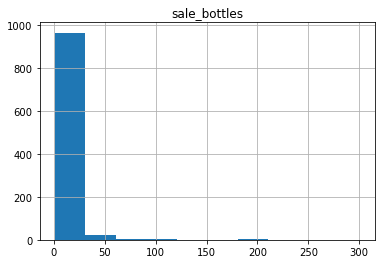

In [189]:
# Making a histogram of the quality variable.
iowa_liquor_sales.hist(column ="sale_bottles")

There is a problem with this variable, sale_bottles is a discrete variable, in that its values are integers (whole numbers) rather than floating point numbers. Thus, sale_bottles is not a continuous variable. But this means that it's actually not the best target for regression analysis.

Before I dismiss the sale_bottles variable, however, let's verify that it's all indeed a discrete variable with some further exploration.

In [190]:
# A great way to get a basic statistical summary of a variable is to call the describe() method on the relevant field. 
iowa_liquor_sales["sale_bottles"].describe()

count    1000.000000
mean        9.907000
std        17.295592
min         1.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       300.000000
Name: sale_bottles, dtype: float64

In [191]:
# Calling .value_counts() on the sale_bottles field with the parameter dropna=False, 
# get a list of the values of the quality variable, and the number of occurrences of each. 
iowa_liquor_sales["sale_bottles"].value_counts(dropna=False)

12     237
6      223
2      125
1      107
3       89
24      72
4       70
5       18
48      12
18      10
36       8
10       5
72       3
30       3
120      3
60       3
8        3
96       2
192      1
84       1
9        1
14       1
204      1
44       1
300      1
Name: sale_bottles, dtype: int64

The outputs of the describe() and value_counts() methods are consistent with our histogram, and since there are just as many values as there are rows in the dataset, we can infer that there are no NAs for the sale_bottles variable.

There are other variables in the dataset that is like the sal_bottle. Those are category, and bottle_volume_ml. So i won't be using them too.

Since the rest of the variables of iowa_liquor_sales dataset are continuous, I could — in theory — pick any of them. But that does not mean that they are all equally sutiable choices. What counts as a suitable dependent variable for regression analysis is determined not just by intrinsic features of the dataset (such as data types, number of NAs etc) but by extrinsic features, such as, simply, which variables are the most interesting or useful to predict, given our aims and values in the context we're in. Almost always, we can only determine which variables are sensible choices for dependent variables with some domain knowledge.

To predict a stockout/retail demand forecasting, one would need to know how many gallons of liquor were sold. Hence, sale_gallons seems would be the independent variable. We should get an idea of which variables are related interestingly to our dependent variable.

We can call the .corr() method on the iowa_liquor_sales data to look at all the correlations between our variables



In [192]:
iowa_liquor_sales.corr()

,category,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_gallons
category,1.000000,0.011895,0.040929,0.040913,-0.005637,-0.003984,-0.007399
bottle_volume_ml,0.011895,1.000000,0.258168,0.258175,-0.024018,0.104196,0.231592
state_bottle_cost,0.040929,0.258168,1.000000,1.000000,-0.089156,0.156349,0.049319
state_bottle_retail,0.040913,0.258175,1.000000,1.000000,-0.089154,0.156348,0.049321
sale_bottles,-0.005637,-0.024018,-0.089156,-0.089154,1.000000,0.722068,0.817812
sale_dollars,-0.003984,0.104196,0.156349,0.156348,0.722068,1.000000,0.913457
sale_gallons,-0.007399,0.231592,0.049319,0.049321,0.817812,0.913457,1.000000


# 2. Cleaning, Transforming, and Visualizing

# 2a. Visualizing correlations
The heading of this stage of the data science pipeline ('Cleaning, Transforming, and Visualizing') doesn't imply that we have to do all of those operations in that order. Sometimes (and this is a case in point) our data is already relatively clean, and the priority is to do some visualization. Normally, however, our data is less sterile, and we have to do some cleaning and transforming first prior to visualizing.

Now that we've chosen sale_gallons as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.

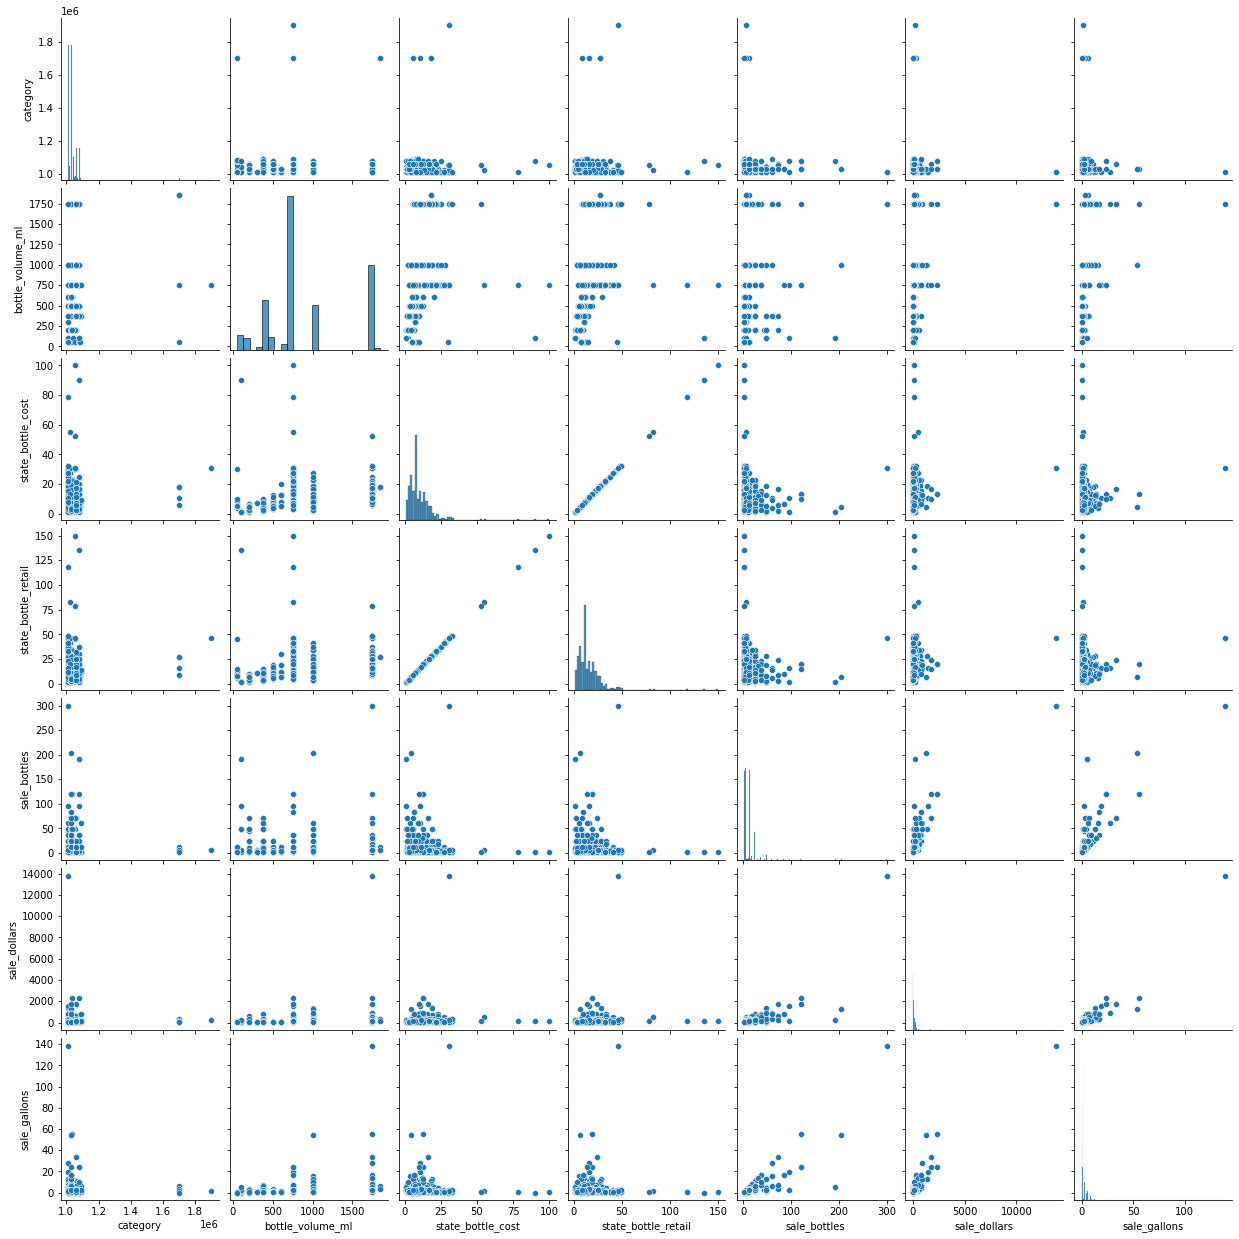

In [193]:
# Call the .pairplot() method on our Seaborn object 'sns', and plug in our iowa_liquor_sales data as a parameter. 
sns.pairplot(iowa_liquor_sales)

Notice that sale_dollars vs sale_gallons plots invite a line of best fit. Others, such as  bottle_volume_ml vs state_bottle_cost, are hard to understand.

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our wine data. Both have flaws. Happily, we can get the best of both worlds with a heatmap

<AxesSubplot:>

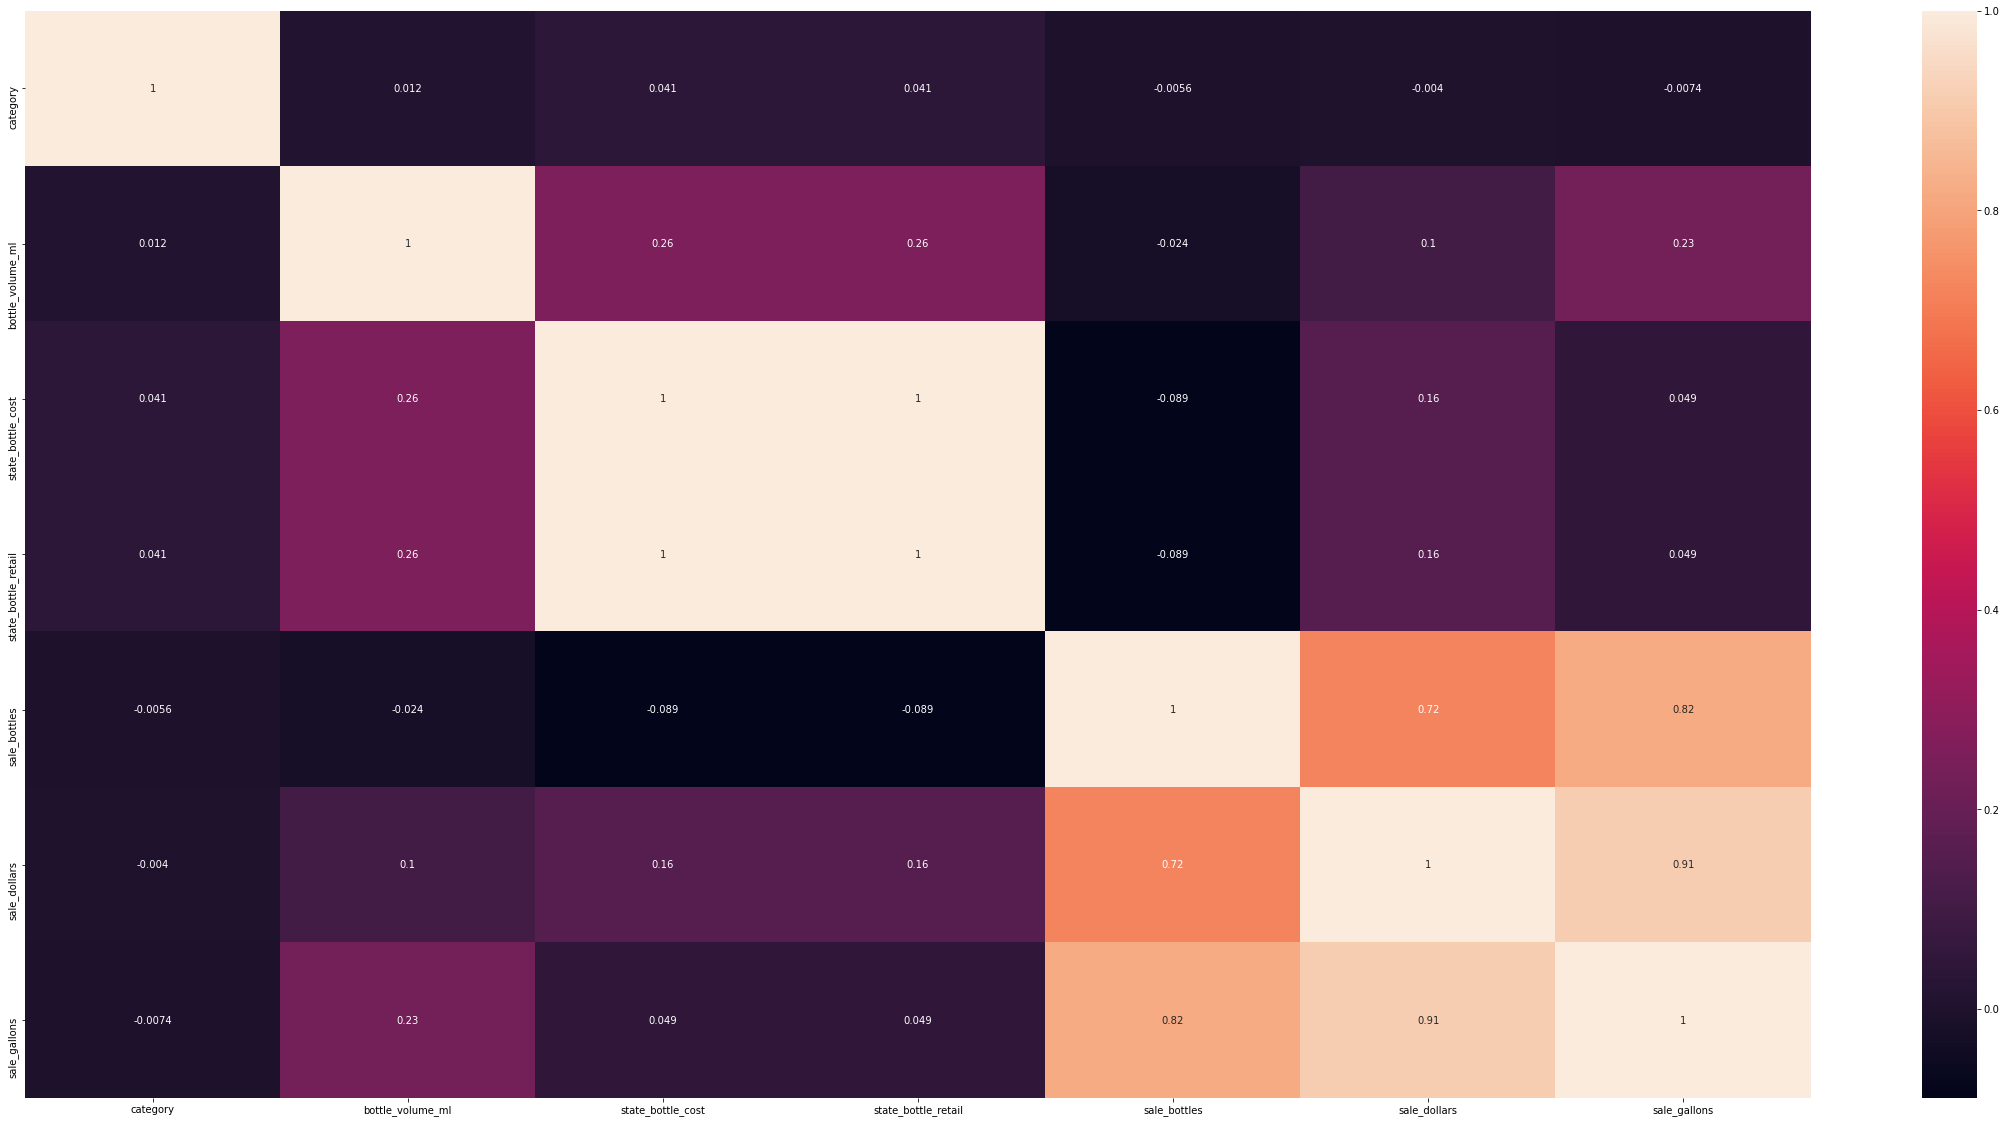

In [194]:
#We need to do some preliminary work, and ensure that the Matplotlib plot is big enough. 
# Call .figure() on plt, and plug in the parameter figsize=(40,20)
plt.figure(figsize=(40,20))

# To create an annotated heatmap of the correlations, we call the heatmap() method on our sns object.
sns.heatmap(iowa_liquor_sales.corr(), annot=True)

There is a relatively strong correlation between the sale_dollars and sale_gallons, followed by sale_bottles and sale_gallons variables respectively.

<AxesSubplot:xlabel='sale_dollars', ylabel='sale_gallons'>

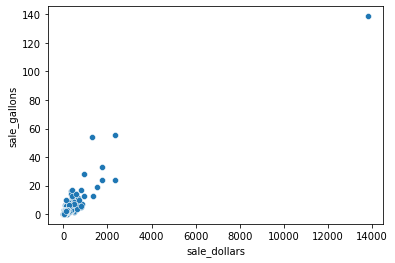

In [195]:
# Plot sale_dollars against sale_gallons
sns.scatterplot(x="sale_dollars",y="sale_gallons", data=iowa_liquor_sales)

We can see a positive correlation. There are few outliers.

<AxesSubplot:xlabel='sale_dollars', ylabel='sale_gallons'>

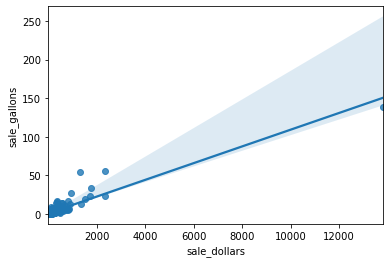

In [196]:
# Call the regplot() method on your sns object
sns.regplot(x="sale_dollars",y="sale_gallons", data=iowa_liquor_sales)

How about sale_bottles vs sale_gallons. let's see

<AxesSubplot:xlabel='sale_bottles', ylabel='sale_gallons'>

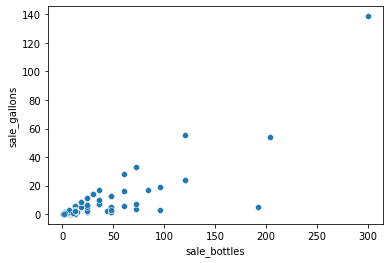

In [197]:
# Plot sale_dollars against sale_gallons
sns.scatterplot(x="sale_bottles",y="sale_gallons", data=iowa_liquor_sales)

<AxesSubplot:xlabel='sale_bottles', ylabel='sale_gallons'>

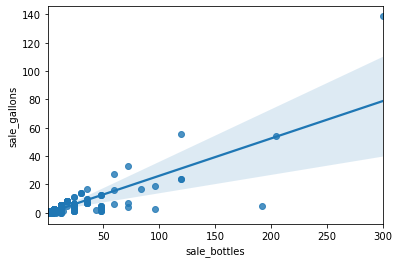

In [198]:
# Call the regplot() method on your sns object
sns.regplot(x="sale_bottles",y="sale_gallons", data=iowa_liquor_sales)

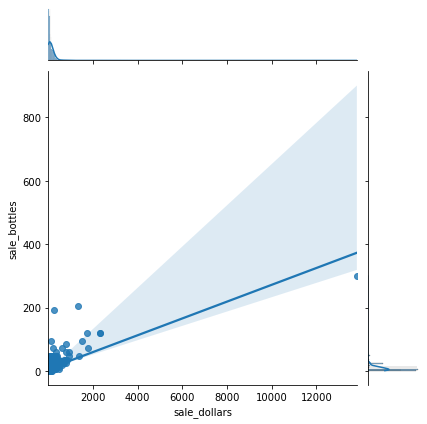

In [199]:
#other variables with high positive correlation at 0.72
#Plot relationship between x='sale_dollars' and'sale_bottles'
sns.jointplot(x='sale_dollars', y='sale_bottles', data=iowa_liquor_sales, kind="reg")

Just like sale_dollars above, there are some outliers, perhaps more. hence we'll not be moving on with this correlation

Let's see if we can predict gallons sold based on dollar amount using linear regression

# 3. Modeling

# 3a. Train/Test Split
While this dataset is super clean, and hence doesn't require much for analysis, we still need to split our dataset into a test set and a training set.Normally, we train with 75% of the data and test on the remaining 25%

To be sure, for our first model, we're only going to focus on two variables: sale_gallons as our dependent variable, and sale_dollars as our sole independent predictor variable

In [200]:
#Subsetting our data into our dependent and independent variables.
# Create a variable called 'X' and assign it the density field of wine.

X = iowa_liquor_sales[["sale_dollars"]] 
y = iowa_liquor_sales[["sale_gallons"]]

# Split the data. This line uses the sklearn function train_test_split().
# The test_size parameter means we can train with 75% of the data, and test on 25%. 
# The random_state parameter allows our work to be checked and replicated by other data scientists
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [201]:
# check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(750, 1) (750, 1)
(250, 1) (250, 1)


# 3b. Making a Linear Regression model: our first model

Sklearn has a LinearRegression() function built into the linear_model module. We'll be using that to make our regression model.

In [202]:
# Create the model. the normalize=True parameter enables the handling of different scales of our variables. 
rModel = linear_model.LinearRegression(normalize=True)

In [203]:
# train the model on our test data.
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [204]:
# Evaluate the model 
rModel.score(X_train, y_train)

0.7194900650201466

The above score is called R-Squared coefficient, or the "coefficient of determination". It's basically a measure of how successfully our model predicts the variations in the data away from the mean: 1 would mean a perfect model that explains 100% of the variation. At the moment, our model explains only about 72% of the variation from the mean.

In [205]:
# Use the model to make predictions about our test data
y_pred = rModel.predict(X_test)

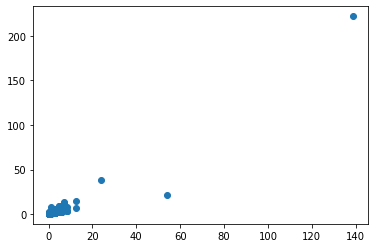

In [206]:
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_test,y_pred)

The above scatterplot represents how well the predictions match the actual results.

Along the x-axis, we have the actual sale_gallons, and along the y-axis we have the predicted value for the sale_gallons.

There is a visible positive correlation, as the model 72% succesful. Let's build a similar model using a different package, to see if we get a better result that way

# 3c. Making a Linear Regression model: our second model: Ordinary Least Squares (OLS)

In [207]:
# Create the test and train sets.
X = iowa_liquor_sales[["sale_dollars"]]

# But here, reassign X the value of adding a constant to it. This is required for Ordinary Least Squares Regression.
# Further explanation of this can be found here: https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html
X = sm.add_constant(X)

y = iowa_liquor_sales[["sale_gallons"]]

# Split the data using train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [208]:
# Create the model
rModel2 = sm.OLS(y_train, X_train)

# Fit the model with fit() 
rModel2_results = rModel2.fit()

In [209]:
# Evaluate the model with .summary()
rModel2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sale_gallons   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     1919.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.17e-208
Time:                        02:23:27   Log-Likelihood:                -1496.4
No. Observations:                 750   AIC:                             2997.
Df Residuals:                     748   BIC:                             3006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2932      0.077      3.793      0.000       0.141       0.445
sale_dollars     0.0161      0.000     43.802      0.000       0.015       0.017
==============================================================================
Omnibus:                      421.980   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14471.243
Skew:                           1.915   Prob(JB):                         0.00
Kurtosis:                      24.176   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared score is 0.719, the same as what it was with the previous model. This makes perfect sense, It's the same value as the score from sklearn, because they've both used the same algorithm on the same data

In [210]:
# Use our new model to make predictions of the dependent variable y. Use predict(), and plug in X_test as the parameter
y_pred = rModel2_results.predict(X_test)

Text(0, 0.5, 'sale_gallons')

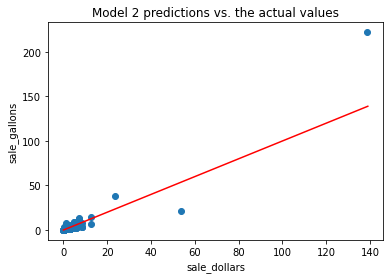

In [211]:
# Plot the predictions
# Build a scatterplot
plt.scatter(y_test, y_pred)

# Add a line for perfect correlation. Can you see what this line is doing? Use plot()
plt.plot([x for x in range(0,140)],[x for x in range(0,140)], color='red')

# Label it nicely
plt.title("Model 2 predictions vs. the actual values")
plt.xlabel("sale_dollars")
plt.ylabel("sale_gallons")

The red line shows a theoretically perfect correlation between our actual and predicted values - the line that would exist if every prediction was completely correct. Let try another model and see if it could give better result

# 3d. Making a Linear Regression model: our third model: multiple linear regression

Including more than one explanatory variable into a linear regression analysis is known as multiple linear regression.

In [218]:
# Create test and train datasets
#X = iowa_liquor_sales.drop(["sale_gallons","sale_dollars"],axis=1)

# Create constants for X, so the model knows its bounds
#X = sm.add_constant(X)
#y = iowa_liquor_sales[["sale_gallons"]]
result = sm.ols(formula="A ~ B + C", data=iowa_liquor_sales).fit()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

AttributeError: 'DataFrame' object has no attribute 'data'

In [217]:
# Create the model
rModel3 = sm.OLS(X_train,y_train)

# Fit the model with fit() 
rModel3_results = rModel3.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).